In [3]:
import os
import time
import string
import glob
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


In [11]:
# checking connection
r = requests.get("https://coinmarketcap.com/currencies/bitcoin/historical-data/")
r.status_code

200

# Scraping function for coinmarket

In [17]:
def scrape_crypto(crypto, period):
    
    url = f"https://coinmarketcap.com/currencies/{crypto}/historical-data/"
    
    # Get path where chrome driver "chromedriver" is stored: for the project purpose it will be in the same folder 
    # where this code file will be kept and running    
    strCurrentWorkingDir=os.getcwd()
    
    # create webdriver object
    driver = webdriver.Chrome(executable_path=strCurrentWorkingDir+"\\chromedriver")
    
    #Get webpage
    driver.get(url)
    time.sleep(3)
    # write script
    JSscript = "window.scrollTo(0,900)"   
    driver.execute_script(JSscript)  #execute_script driver method in Selenium
    
    try:
        lstRange=range(12*period-1)
        print("Period range: ", lstRange)
        for i in lstRange:
            time.sleep(1)
            button = driver.find_element_by_xpath('//button[@class="x0o17e-0 DChGS"]')
            driver.execute_script("arguments[0].scrollIntoView();", button)
            button.send_keys(Keys.UP,Keys.UP,Keys.UP,Keys.UP,Keys.UP,Keys.UP)
            time.sleep(1)
            button.click()
    except:
        pass

    html = driver.page_source
    df = pd.read_html(html)[0]
    df = df.replace('\$','',regex=True)
    
    driver.close()
    
    print("{}'s data scraped for the last {} year(s) successfully.".format(crypto, period))
    
    # Adding one more column to identify the
    df['CryptoName']=crypto
    
    return df

In [18]:
def get_data_from_coinmarketcap(cryptos, period): 
    lstGroups = []

    start = time.time()
    for i in cryptos:
        lstGroups.append(scrape_crypto(i,period))
    end = time.time()

    print("\nTook about: {} mins".format((end-start)/60))

    pdAllaData=pd.concat(lstGroups)
    pdAllaData=pdAllaData.reset_index()[list(pdAllaData.columns)]
    
    
    # Pre-process data
    pdAllaData=make_data_ready_for_eda(pdAllaData)

    return pdAllaData

# --- Preprocessing ---

def make_data_ready_for_eda(pdAllaData):
    
    # 1. Rename columns
    pdAllaData.rename(columns={"Open*":"Open", "Close**": "Close", "Market Cap": "MarketCap"}, inplace=True)
    
    from datetime import datetime
    # 2. Date: Oct 25, 2021 => 2021-10-25
    pdAllaData['Date']=pd.to_datetime(pdAllaData.Date)
    
    # 3. get numbers
    pdAllaData=process_string_covert_to_float(pdAllaData)
    
    return pdAllaData

def process_string_covert_to_float(pdAllaData): 
    for colName in ['Open', 'High', 'Low', 'Close', 'Volume', 'MarketCap']:
        try:
            pdAllaData[colName]=pdAllaData[colName].apply(lambda x: x.replace(',', ''))
            pdAllaData[colName]=pdAllaData[colName].astype(float)
        except:
            pass
    return pdAllaData

In [19]:
cryptos = ['bitcoin', 'ethereum', 'cardano', 'tether', 'binance-coin']
period = 5

In [20]:
%time pdAllaData=get_data_from_coinmarketcap(cryptos, period)

/var/folders/x2/hrynvsvx3qnf1grxmxs_9d2m0000gn/T/ipykernel_32160/2874010335.py:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path="./chromedriver") #version 93


Period range:  range(0, 59)


/var/folders/x2/hrynvsvx3qnf1grxmxs_9d2m0000gn/T/ipykernel_32160/2874010335.py:26: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  button = driver.find_element_by_xpath('//button[@class="x0o17e-0 DChGS"]')


bitcoin's data scraped for the last 5 year(s) successfully.
Period range:  range(0, 59)
ethereum's data scraped for the last 5 year(s) successfully.
Period range:  range(0, 59)
cardano's data scraped for the last 5 year(s) successfully.
Period range:  range(0, 59)
tether's data scraped for the last 5 year(s) successfully.
Period range:  range(0, 59)
binance-coin's data scraped for the last 5 year(s) successfully.

Took about: 10.874004300435384 mins
CPU times: user 2.27 s, sys: 346 ms, total: 2.62 s
Wall time: 10min 52s


In [21]:
pdAllaData.rename(columns={"Market Cap": "MarketCap"}, inplace=True)

In [22]:
pdAllaData.to_csv("5_years_data_top_crypto.csv", index=False)

In [23]:
pdAllaData.head()

,Date,Open,High,Low,Close,Volume,MarketCap,CryptoName
0,2021-10-28,58470.73,62128.63,58206.92,60622.14,4.525708e+10,1.143166e+12,bitcoin
1,2021-10-27,60352.00,61435.18,58208.19,58482.39,4.365708e+10,1.102758e+12,bitcoin
2,2021-10-26,63032.76,63229.03,59991.16,60363.79,3.487897e+10,1.138178e+12,bitcoin
3,2021-10-25,60893.93,63729.33,60691.80,63039.83,3.106491e+10,1.188575e+12,bitcoin
4,2021-10-24,61368.34,61505.80,59643.35,60930.84,2.731618e+10,1.148743e+12,bitcoin


Description of the dataframe columns:

1)Date - Date range of cryptocurrency for analysis

2)Open - Price of the cryptocurrency at the Start of the Day

3)High - Highest Price of the cryptocurrency

4)Low  -Lowest Price of the cryptocurrency

5)Close -Price of the cryptocurrency at the End of the Day

6)Volume -Volume is the amount of assets traded during a specific time frame

7)MarketCap -Total value of cryptocurrency.

8)CryptoName - Name of the cryptocurrency.


# EDA

In [107]:
print("We have data from {} to {}".format(pdAllaData.Date.min(), pdAllaData.Date.max()))

We have data from 2016-10-26 00:00:00 to 2021-10-26 00:00:00


# 1)Analysis on top 5 currencies
- Market capitalisation (market cap) is an indicator that measures and keeps track of the market value of a cryptocurrency. In other words, it is the real value of a cryptocurrency.
- Well, the Market Cap of a cryptocurrency is calculated by multiplying the Circulating Supply with the price of the coin or token(market cap= Circulating Supply * Price).

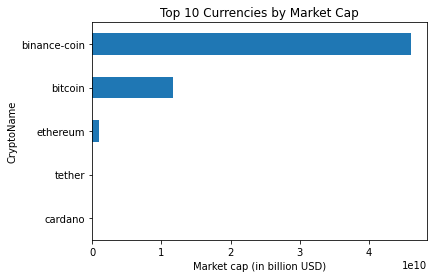

In [24]:
ax = (pdAllaData.groupby(['CryptoName'])['MarketCap']).last().sort_values(ascending=False).head(5).sort_values().plot(kind='barh');
ax.set_xlabel("Market cap (in billion USD)");
plt.title("Top 10 Currencies by Market Cap");

In [25]:
pdAllaData['market_billion']= pdAllaData['MarketCap'] / 1000000000
pdAllaData.groupby(['CryptoName'])['market_billion'].last().sort_values(ascending=False)

CryptoName
binance-coin    46.062328
bitcoin         11.642864
ethereum         0.921057
tether           0.006952
cardano          0.000000
Name: market_billion, dtype: float64

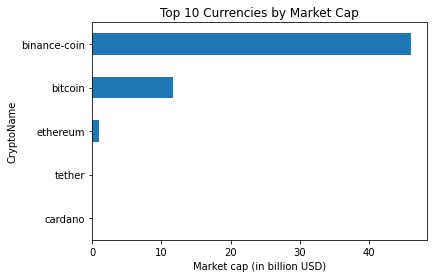

In [26]:
ax = (pdAllaData.groupby(['CryptoName'])['market_billion']).last().sort_values(ascending=False).head(5).sort_values().plot(kind='barh');
ax.set_xlabel("Market cap (in billion USD)");
plt.title("Top 10 Currencies by Market Cap");

# 2)Percentage change in closing price analysis

In [27]:
import numpy as np

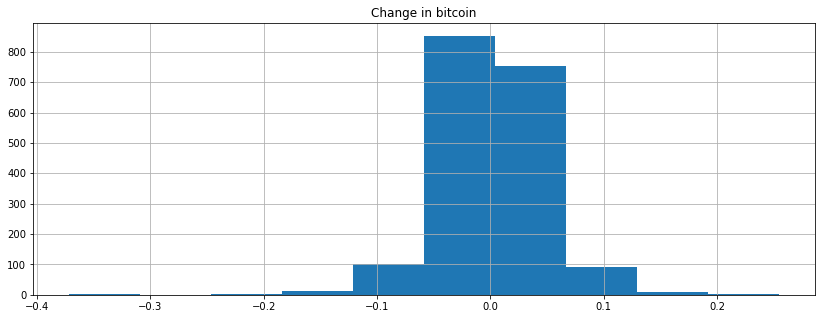

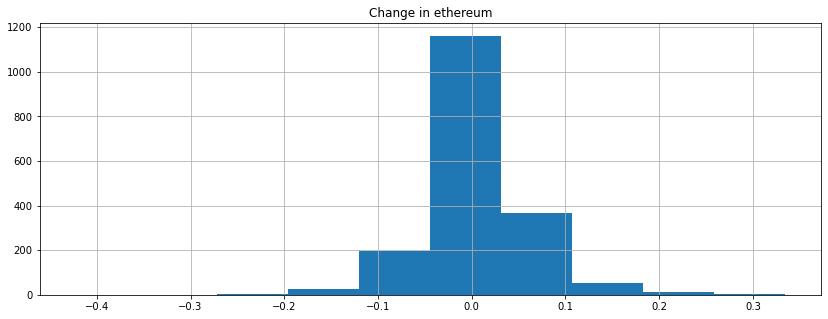

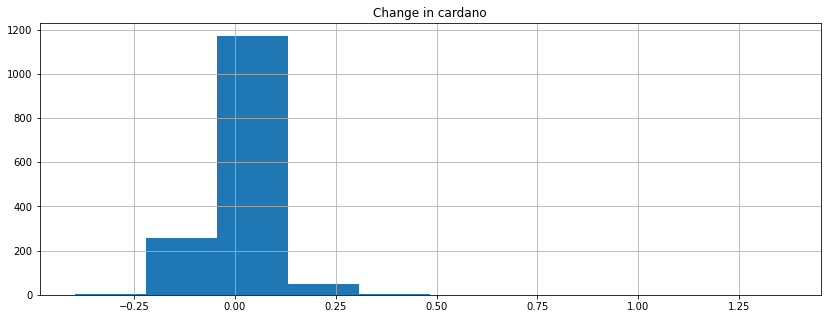

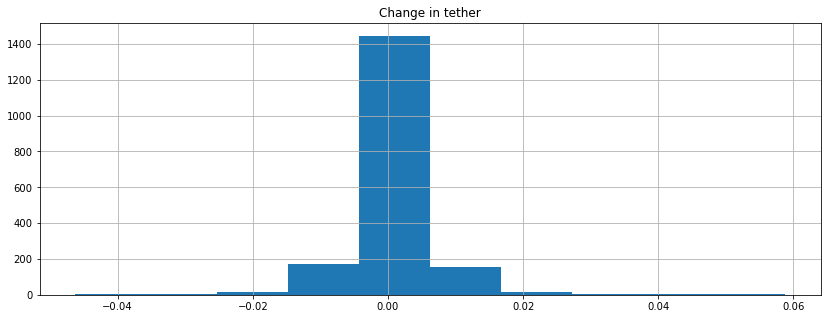

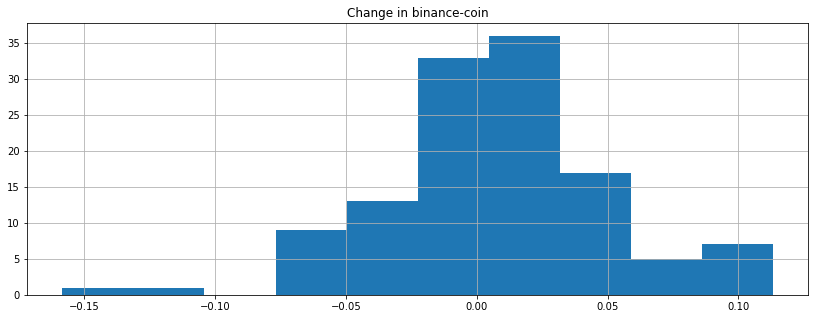

In [28]:
#Formula = ((close - open) / open) * 100
pdAllaData['Change']=(pdAllaData['Close']-pdAllaData['Open'])/pdAllaData['Open']

for Crypto in list(pdAllaData['CryptoName'].unique()):
    plt.title("Change in "+Crypto)
    pdAllaData[pdAllaData['CryptoName'] == Crypto]['Change'].hist(figsize=(14, 5))
    plt.show()

In [29]:
#Formula = ((close - open) / open) * 100
pdAllaData['Perc_Change']=np.abs(100*(pdAllaData['Close']-pdAllaData['Open'])/pdAllaData['Open'])

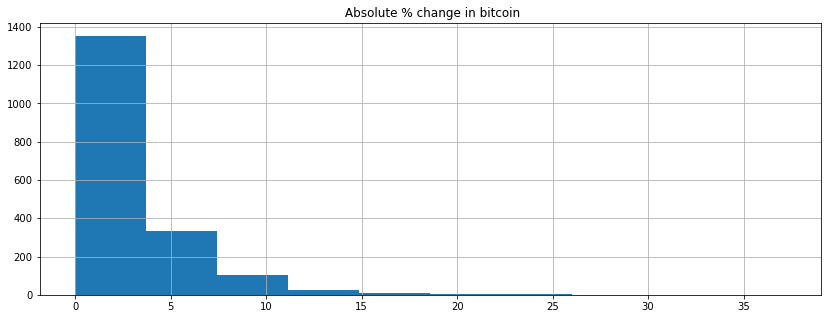

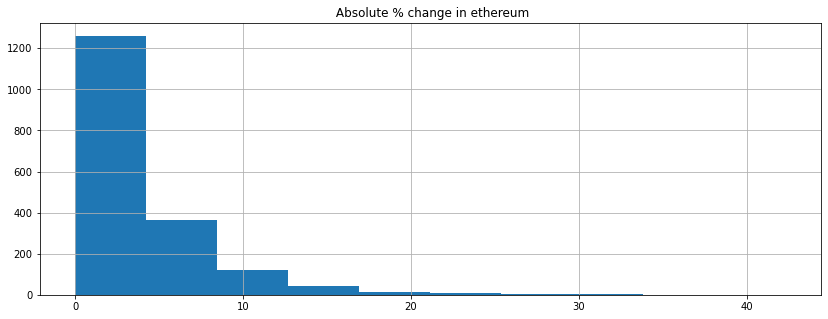

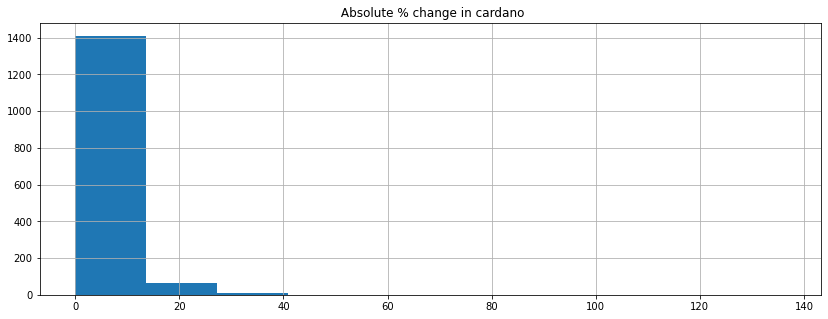

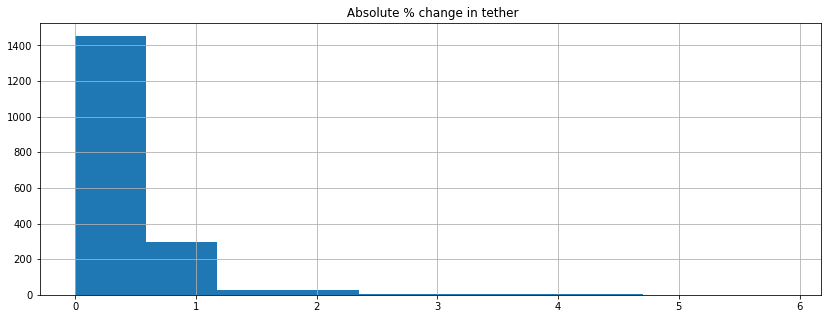

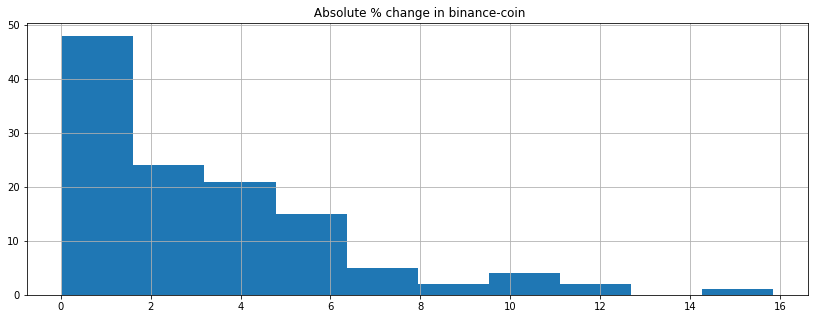

In [30]:
for Crypto in list(pdAllaData['CryptoName'].unique()):
    plt.title(" Absolute % change in "+Crypto)
    pdAllaData[pdAllaData['CryptoName'] == Crypto]['Perc_Change'].hist(figsize=(14, 5))
    plt.show()

# 3) Close price values analysis

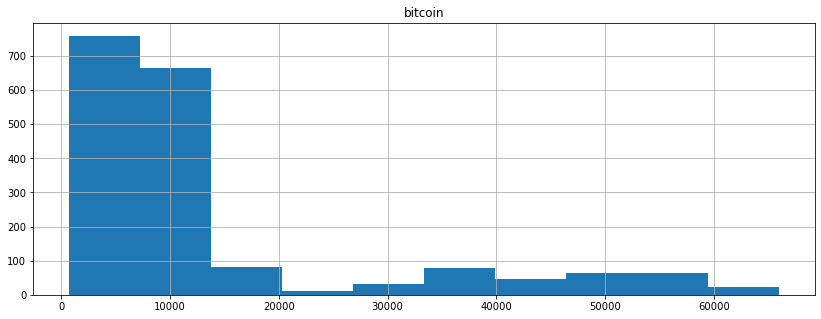

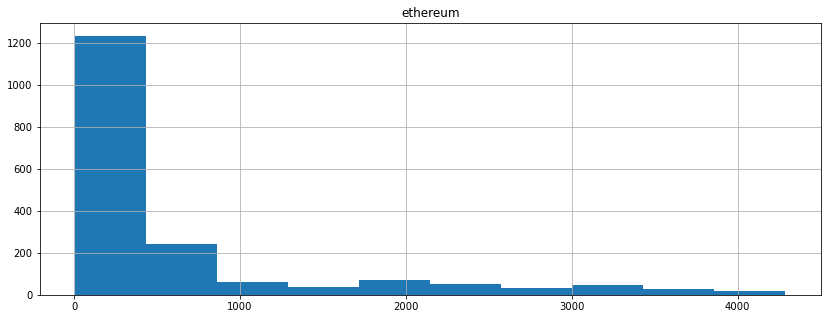

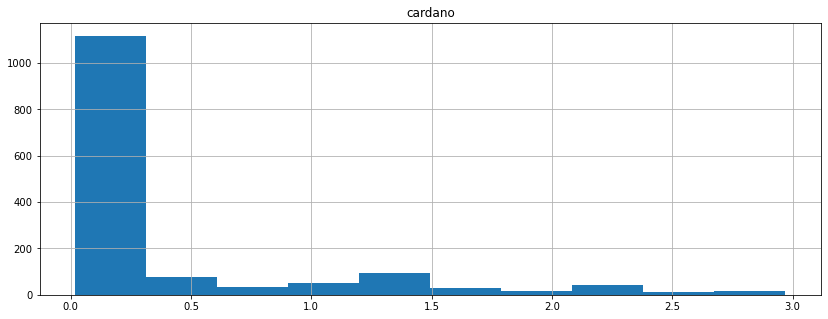

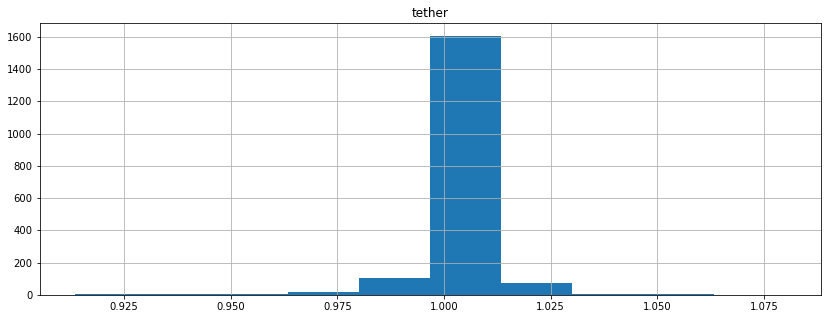

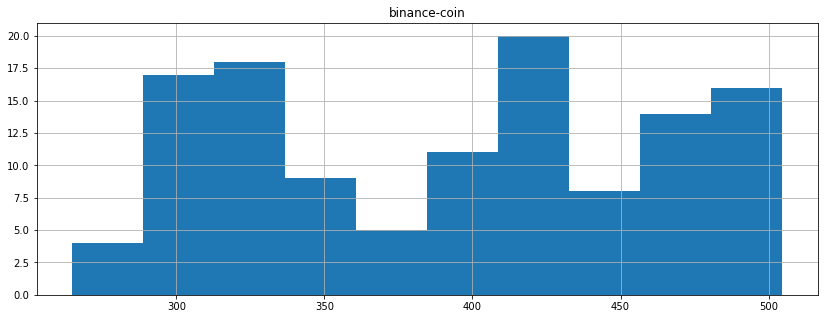

In [31]:
for Crypto in list(pdAllaData['CryptoName'].unique()):
    plt.title(Crypto)
    pdAllaData[pdAllaData['CryptoName'] == Crypto]['Close'].hist(figsize=(14, 5))
    plt.show()

In [32]:
pdAllaData.groupby('CryptoName').sum()

,Open,High,Low,Close,Volume,MarketCap,market_billion,Change,Perc_Change
CryptoName,,,,,,,,,
binance-coin,4.770951e+04,4.927192e+04,4.623107e+04,4.792183e+04,2.379178e+11,7.964675e+12,7964.674879,0.667156,387.842098
bitcoin,2.476480e+07,2.547339e+07,2.401100e+07,2.482465e+07,3.638255e+13,4.534414e+14,453441.425564,5.976175,5121.346430
cardano,5.807660e+02,6.096213e+02,5.508673e+02,5.828097e+02,1.652968e+12,1.787494e+13,17874.944209,8.893682,7109.716564
ethereum,1.176076e+06,1.221225e+06,1.127675e+06,1.180318e+06,1.756757e+13,1.314605e+14,131460.506137,8.602613,6924.201687
tether,1.824273e+03,1.839035e+03,1.813568e+03,1.824406e+03,5.311952e+13,2.169786e+13,21697.859459,0.168873,521.939907


# 4) Auto-correlation for close price

<AxesSubplot:title={'center':'Close Values'}, xlabel='Date'>

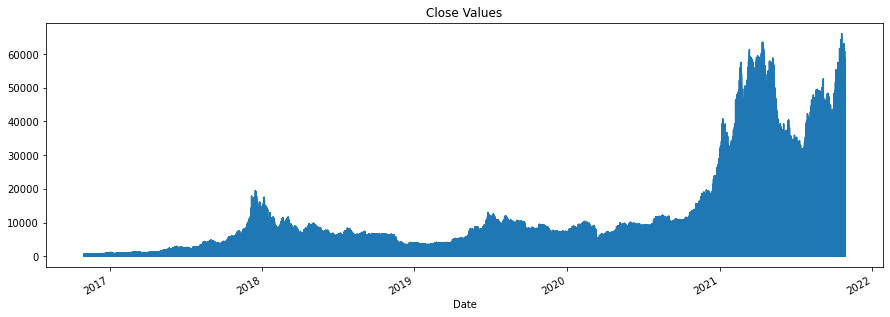

In [33]:
pdAllaData.set_index("Date")['Close'].plot(figsize=(15,5), title="Close Values")

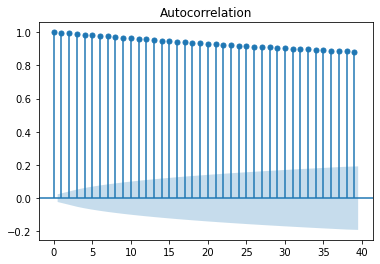

In [34]:
series=pdAllaData['Close']
plot_acf(series)
plt.show()

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

source: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

In [35]:
pdAllaData.describe()

,Open,High,Low,Close,Volume,MarketCap,market_billion,Change,Perc_Change
count,7080.000000,7080.000000,7080.000000,7080.000000,7.080000e+03,7.080000e+03,7080.000000,7080.000000,7080.000000
mean,3671.044079,3777.730283,3557.524717,3680.126936,1.538991e+10,8.932760e+10,89.327600,0.003433,2.834046
std,9737.837512,10026.692922,9425.456325,9761.310837,2.552025e+10,1.847558e+11,184.755809,0.051930,4.364902
min,0.018410,0.021050,0.017350,0.018540,2.072200e+05,0.000000e+00,0.000000,-0.423077,0.000000
25%,1.000000,1.000000,0.993900,1.000000,4.201134e+08,2.767304e+09,2.767304,-0.011665,0.285518
50%,109.830000,116.320000,105.850000,110.110000,4.147447e+09,2.073243e+10,20.732433,0.000000,1.410303
75%,2247.830000,2348.240000,2140.312500,2273.710000,2.026345e+10,7.861881e+10,78.618812,0.015870,3.822313
max,66002.230000,66930.390000,63610.670000,65992.840000,3.509679e+11,1.243927e+12,1243.927428,1.364211,136.421094


# 5) Cryptocurrency trend

In [ ]:
# Let's prepare one dataframe where we will observe closing prices for each currency that are latest
wide_format = pdAllaData.groupby(['Date', 'CryptoName'])['Close'].last().unstack()

In [37]:
wide_format.describe()

CryptoName,binance-coin,bitcoin,cardano,ethereum,tether
count,122.000000,1823.000000,1489.000000,1823.000000,1823.000000
mean,392.801885,13617.471925,0.391410,647.459320,1.000771
std,69.628014,15363.893470,0.631022,901.945161,0.009590
min,264.780000,688.700000,0.018540,6.820000,0.913600
25%,322.790000,4371.205000,0.047780,167.045000,1.000000
50%,405.300000,8206.150000,0.094220,269.020000,1.000000
75%,453.467500,11596.295000,0.313600,597.955000,1.000000
max,504.620000,65992.840000,2.970000,4287.320000,1.080000


Observation: To answer the question which currencies are more stable and which ones are more volatible , higher the volatality
means the variance/std is higher . Here we can see that Bitcoin has highest variance so highly volatile and tether is more stable.

# 6) Which Currency has the highest Market Capital?

In [38]:
pdAllaData.iloc[5000:]

,Date,Open,High,Low,Close,Volume,MarketCap,CryptoName,market_billion,Change,Perc_Change
5000,2018-02-12,0.3726,0.3933,0.3726,0.3843,2.430390e+08,9.964162e+09,cardano,9.964162,0.031401,3.140097
5001,2018-02-11,0.4051,0.4052,0.3636,0.3698,3.319440e+08,9.587027e+09,cardano,9.587027,-0.087139,8.713898
5002,2018-02-10,0.3867,0.4628,0.3854,0.4059,9.518240e+08,1.052307e+10,cardano,10.523072,0.049651,4.965089
5003,2018-02-09,0.3528,0.3941,0.3429,0.3916,4.012710e+08,1.015309e+10,cardano,10.153093,0.109977,10.997732
5004,2018-02-08,0.3445,0.3675,0.3368,0.3566,3.463830e+08,9.245179e+09,cardano,9.245179,0.035123,3.512337
...,...,...,...,...,...,...,...,...,...,...,...
7075,2021-07-03,287.2200,302.6100,283.4300,298.2400,1.113777e+09,4.575938e+10,binance-coin,45.759385,0.038368,3.836780
7076,2021-07-02,287.7500,290.6200,277.3500,287.4200,1.133633e+09,4.410016e+10,binance-coin,44.100158,-0.001147,0.114683
7077,2021-07-01,303.5300,303.5300,281.5800,288.2200,1.357795e+09,4.422218e+10,binance-coin,44.222185,-0.050440,5.043982
7078,2021-06-30,300.9600,304.8000,281.7800,303.3000,1.903538e+09,4.653557e+10,binance-coin,46.535565,0.007775,0.777512


CryptoName
binance-coin    4.606233e+10
bitcoin         1.164286e+10
ethereum        9.210574e+08
tether          6.951589e+06
cardano         0.000000e+00
Name: MarketCap, dtype: float64

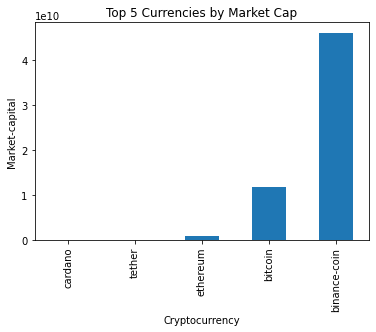

In [39]:
ax = pdAllaData.groupby(['CryptoName'])['MarketCap'].last().sort_values(ascending=False).head(5).sort_values().plot(kind='bar');
ax.set_xlabel("Cryptocurrency");
ax.set_ylabel("Market-capital");
plt.title("Top 5 Currencies by Market Cap");

top_currency = pdAllaData.groupby(['CryptoName'])['MarketCap'].last().sort_values(ascending=False)
top_currency

Observation: We can observe tht 'bitcoin' has the highest MarketCapital and 'ethereum' has the second highest.

# 7) Cryptocurrency transaction volume analysis

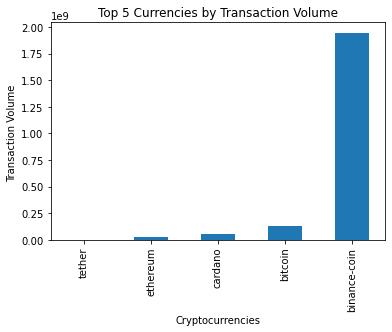

In [40]:
ax = pdAllaData.groupby(['CryptoName'])['Volume'].last().sort_values(ascending=False).head(5).sort_values().plot(kind='bar');
ax.set_xlabel("Cryptocurrencies");
ax.set_ylabel("Transaction Volume ");
plt.title("Top 5 Currencies by Transaction Volume");

Observation: Here from the above bar chart we can clearly see that bitcoin has the highest transaction volume and binance-coin has the least transaction volume.

# 8) Which Year has the highest closing price value for Crypto currencies?

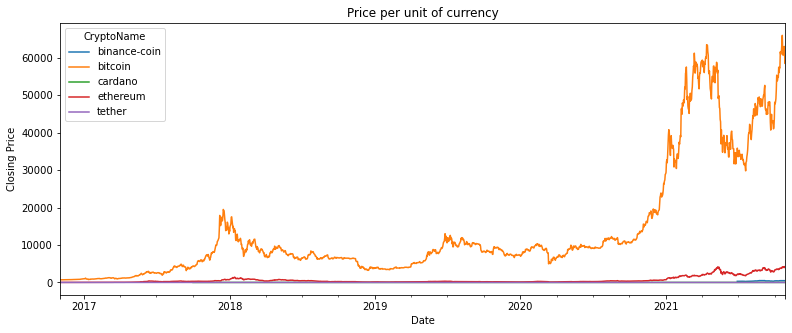

In [41]:
ax = pdAllaData.groupby(['Date', 'CryptoName'])['Close'].mean().unstack().plot(figsize=(13, 5));
ax.set_ylabel("Closing Price");
plt.title("Price per unit of currency");

Observation:Here from the plot we can see that bitcoin has the highest closing price and among that the highest price was at 2021 year and the lowest/least was found at 2016.

# 9) Time Series plot of Crypto currencies for Market Capital Values

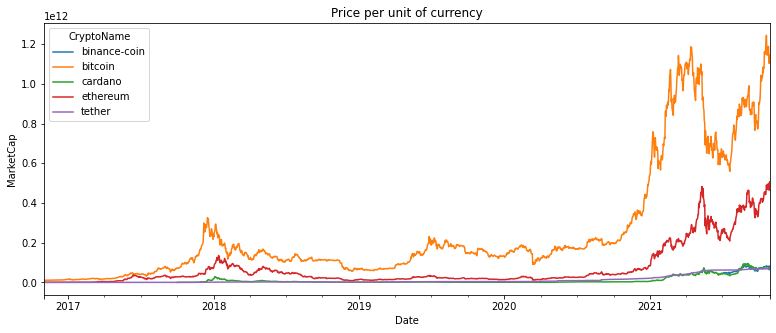

In [42]:
ax = pdAllaData.groupby(['Date', 'CryptoName'])['MarketCap'].mean().unstack().plot(figsize=(13, 5));
ax.set_ylabel("MarketCap");
plt.title("Price per unit of currency");

Observation:Here from the plot we can see that bitcoin has the highest MarketCap and among that the highest price was between 2020 and 2021 december and august respectively

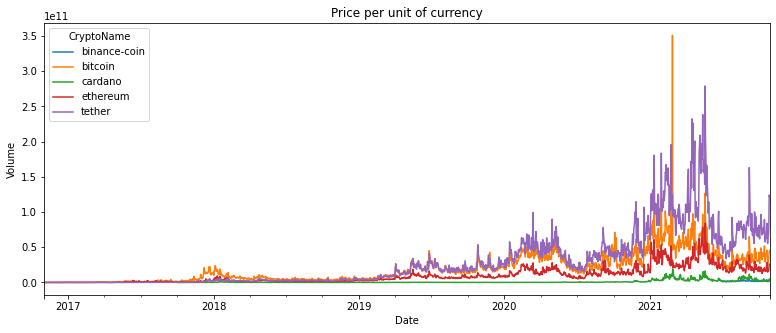

In [43]:
ax = pdAllaData.groupby(['Date', 'CryptoName'])['Volume'].mean().unstack().plot(figsize=(13, 5));
ax.set_ylabel("Volume");
plt.title("Price per unit of currency");

Text(0.5, 1.0, 'Price Value After 2017')

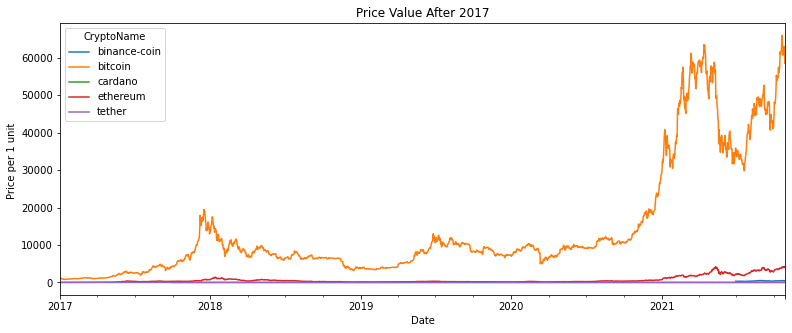

In [44]:
ax = pdAllaData[pd.DatetimeIndex(pdAllaData['Date']).year >= 2017].groupby(['Date', 'CryptoName'])['Close'].mean().unstack().plot(figsize=(13, 5));
ax.set_ylabel("Price per 1 unit ");
plt.title("Price Value After 2017")